# Load in the data - X-Fact

In [5]:
import pandas as pd
import os
#os.chdir(r'C:\Users\...') - this line is what I've been using to solve a no such directory error - copy paste the path of data folder
df = pd.read_csv(r"x_fact_dataset/x-fact-including-en/train.all.tsv", delimiter="\t", on_bad_lines="skip")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30492 entries, 0 to 30491
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   language    30492 non-null  object
 1   site        30492 non-null  object
 2   evidence_1  30031 non-null  object
 3   evidence_2  29958 non-null  object
 4   evidence_3  30305 non-null  object
 5   evidence_4  30269 non-null  object
 6   evidence_5  30262 non-null  object
 7   link_1      30350 non-null  object
 8   link_2      30335 non-null  object
 9   link_3      30334 non-null  object
 10  link_4      30334 non-null  object
 11  link_5      30334 non-null  object
 12  claimDate   30332 non-null  object
 13  reviewDate  30330 non-null  object
 14  claimant    30319 non-null  object
 15  claim       30249 non-null  object
 16  label       30162 non-null  object
dtypes: object(17)
memory usage: 4.0+ MB
None


,language,site,evidence_1,evidence_2,evidence_3,evidence_4,evidence_5,link_1,link_2,link_3,link_4,link_5,claimDate,reviewDate,claimant,claim,label
0,tr,dogrulukpayi.com,"Son 50 yılın siyasi tarihine bakın, tek başına...","Son 50 yılın siyasi tarihine bakın, tek başına...",Türkiye potansiyelini doğru kullanıp yüzde 7 b...,2020/01/02 — Türkiye Cumhuriyeti tarihinde hiç...,2002/12/09 — Cumhuriyet tarihi boyunca tek par...,https://www.dogrulukpayi.com/iddia-kontrolu/so...,https://www.dogrulukpayi.com/yazar/furkan-demi...,https://businessht.bloomberght.com/yazarlar/ca...,https://www.mahfiegilmez.com/2020/01/turkiye-e...,https://www.hurriyet.com.tr/ekonomi/tek-parti-...,none,none,Binali Yıldırım,"Son 50 yılın siyasi tarihine bakın, tek başına...",false
1,ka,factcheck.ge,"Oct 4, 2018 — იტალიის სამაშველო სამსახურებს მი...",ევროპული ღირებულებები - იტალიის სამაშველო სამს...,ევროპული ღირებულებები - იტალიის სამაშველო სამს...,<DUMMY_EVIDENCE>,<DUMMY_EVIDENCE>,https://factcheck.ge/ka/story/37352-evropuli-g...,https://factcheck.ge/ka/page/persons/thbilisi-24,http://142.93.167.204/ka/page/persons/thbilisi-24,NO_LINK,NO_LINK,none,none,თბილისი 24,ევროპული ღირებულებები - იტალიის სამაშველო სამს...,partly true/misleading
2,pt,piaui.folha.uol.com.br,"03.11.2020 — “Aqui em São Paulo, nós estamos c...","03.11.2020 — ... França erra sobre creches, mo...",05.06.2020 — A lei aprovada pelo Congresso que...,Caixa paga auxílio emergencial de R$ 600 e R$ ...,"7 de julho de 2020, 15:20h ... Porém, diferent...",https://piaui.folha.uol.com.br/lupa/2020/11/03...,https://www1.folha.uol.com.br/poder/2020/11/na...,https://g1.globo.com/economia/noticia/2020/06/...,https://jc.ne10.uol.com.br/economia/2020/11/11...,https://noticiasconcursos.com.br/direitos-trab...,2020-11-03T12:41:12Z,2020-11-03T12:41:12Z,Márcio França (PSB),"Aqui em São Paulo, nós estamos com 2,7 milhões...",partly true/misleading
3,ka,factcheck.ge,"Sep 12, 2016 — ირაკლი ხახუბია, ""ნაციონალური მო...","ირაკლი ხახუბია, ""ნაციონალური მოძრაობის"" სპონსო...","ირაკლი ხახუბია, ""ნაციონალური მოძრაობის"" სპონსო...","ირაკლი ხახუბია, ""ნაციონალური მოძრაობის"" სპონსო...",<DUMMY_EVIDENCE>,https://factcheck.ge/ka/story/23935-irakli-kha...,https://factcheck.ge/ka/stories/archive?page=128,http://142.93.167.204/ka/stories/archive?page=140,http://142.93.167.204/ka/topics/%E1%83%9E%E1%8...,NO_LINK,none,none,შალვა ნათელაშვილი,"ირაკლი ხახუბია, ""ნაციონალური მოძრაობის"" სპონსო...",true
4,id,cekfakta.com,"Sep 18, 2018 — Akun @lambeturah memposting seb...",[SALAH] Zumi Zola Jalan-Jalan Di Bandara Soeka...,[DISINFORMASI] Zumi Zola Jalan-Jalan Di Bandar...,"Sep 17, 2018 — JAKARTA, KOMPAS.com - Pengacara...","Sep 17, 2018 — Jakarta, CNN Indonesia -- Sebua...",https://turnbackhoax.id/2018/09/18/salah-zumi-...,https://ru-ru.facebook.com/groups/fafhh/permal...,https://cekfakta.com/focus/459,https://nasional.kompas.com/read/2018/09/17/10...,https://www.cnnindonesia.com/nasional/20180917...,none,2018-09-18T00:00:00Z,none,Zumi Zola Jalan-Jalan Di Bandara Soekarno-Hatta,false


# Get results from Cohere

In [7]:
import cohere
co = cohere.Client("5m39mdGRD2LzV5YwXOTVOigGzREZUD84nUtJ99K4")

In [8]:
import time
from tqdm import trange

cohere_resp = []

for i in trange(50):
    tmp = {"cohere_resp":None, "index":i, "label":df["label"][i]}
    claim = df["claim"][i]
    response = co.chat(
        message=f"Rate the truthfulness of the following statement: {claim} Provide a score from 0 to 100, where 0 represents definitively false and 100 represents definitively true. Do not provide any explanations, only respond with the numerical score.",
        connectors=[{"id": "web-search"}]
    )
    tmp["cohere_resp"] = response.text
    cohere_resp.append(tmp)
    time.sleep(1)

100%|██████████| 50/50 [07:40<00:00,  9.21s/it]


In [9]:
import termcolor
df_results0 = pd.DataFrame(cohere_resp)

for i in range(df_results0.shape[0]):
    print(termcolor.colored("Claim language: ", "green")+df["language"][i])
    true_label = df_results0["label"][i]
    print(termcolor.colored("True label: ","magenta")+ termcolor.colored(true_label,"magenta"))
    print(termcolor.colored("Zero-Shot Response: ", "cyan")+df_results0["cohere_resp"][i])
    print("\n---\n")

Claim language: tr
True label: false
Zero-Shot Response: 52.5

---

Claim language: ka
True label: partly true/misleading
Zero-Shot Response: I am sorry, I am unable to rate the truthfulness of the statement as it is not clear to me what the statement is referring to. If you would like to provide additional context or clarify the statement, please let me know and I will be happy to assist you to the best of my abilities.

---

Claim language: pt
True label: partly true/misleading
Zero-Shot Response: 85

---

Claim language: ka
True label: true
Zero-Shot Response: 85

---

Claim language: id
True label: false
Zero-Shot Response: 15

---

Claim language: pt
True label: mostly true
Zero-Shot Response: 85

---

Claim language: sr
True label: true
Zero-Shot Response: 85

---

Claim language: it
True label: mostly true
Zero-Shot Response: 25

---

Claim language: id
True label: partly true/misleading
Zero-Shot Response: 30

---

Claim language: id
True label: false
Zero-Shot Response: 75

--

# Recovering Old Results

In [ ]:
df_results0 = pd.read_csv(r"cohere_results", delimiter=",", on_bad_lines="skip")

# Analysis

In [10]:
#simplify the truth-value to binary, so we can approximate some accuracy by delineating false as anything below 50
def simplify_truth(row):
    if row['label'] in ['false', 'mostly false', 'partly true/misleading']:
        return 'false'
    else:
        return 'true'
    

df_results0['simple_truth'] = df_results0.apply(simplify_truth, axis=1)

#simplify cohere response to a binary truth-value
def cohere_tv(row):
    resp = row['cohere_resp']

    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp > 50:
        return "true"
    
    else:
        return "false"
    

df_results0['cohere_simple'] = df_results0.apply(cohere_tv, axis=1)
    
#add the language values
#df2 = pd.concat([df2, extracted_col.rename("Col3_from_df1")], axis=1)

extracted_col = df["language"].head(50)
df_results0 = pd.concat([df_results0, extracted_col.rename("language")], axis=1)

df_results0.head()


,cohere_resp,index,label,simple_truth,cohere_simple,language
0,52.5,0,false,false,true,tr
1,"I am sorry, I am unable to rate the truthfulne...",1,partly true/misleading,false,unknown,ka
2,85,2,partly true/misleading,false,true,pt
3,85,3,true,true,true,ka
4,15,4,false,false,false,id


C:\Users\annal\AppData\Local\Temp\ipykernel_18504\2377360093.py:16: FutureWarning: The provided callable <function mean at 0x000001E1249B0180> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_simple = df_results0.groupby("language")["match"].agg(np.mean)


<Axes: title={'center': 'Accuracy by Language'}, xlabel='language'>

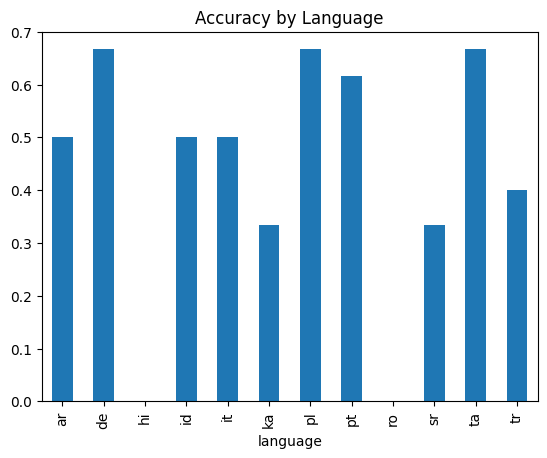

In [18]:
import numpy as np
import matplotlib.pyplot as plt

#check if cohere results match, by language

#make a new column for whether cohere matches by language
def match_tv(row):
    if row['simple_truth'] == row['cohere_simple']:
        return 1
    else:
        return 0

df_results0['match'] = df_results0.apply(match_tv, axis=1)

#1 means everything was right, 0 means everything was wrong (since a 1 was added for a match, a 0 was added otherwise)
df_simple = df_results0.groupby("language")["match"].agg(np.mean)

df_simple.plot.bar("match", title="Accuracy by Language")



C:\Users\annal\AppData\Local\Temp\ipykernel_18504\1302075777.py:10: FutureWarning: The provided callable <function mean at 0x000001E1249B0180> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_understood = df_results0.groupby("language")["understood"].agg(np.mean)


<Axes: title={'center': 'Task Understanding by language'}, xlabel='language'>

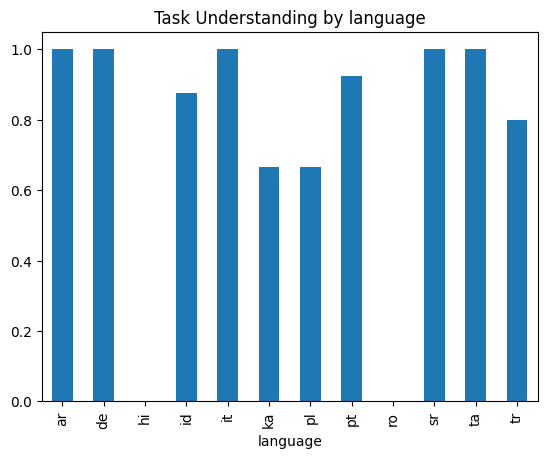

In [44]:
#looking at how well cohere understood the task and responded as it was supposed to
def task_understood(row):
    if row['cohere_simple'] == 'unknown':
        return 0
    else:
        return 1
    
df_results0['understood'] = df_results0.apply(task_understood, axis=1)

df_understood = df_results0.groupby("language")["understood"].agg(np.mean)

df_understood.plot.bar("understood", title="Task Understanding by language")

# Giving Cohere a little help?
In most cases where Cohere doesn't provide a numerical answer, it provides an answer with some explanation (which we didn't want) and the score, usually in a sentence like "I give this claim a score of...". Let's try to use that data:

In [72]:
import re

def cohere_tv_help(row):
    resp = row['cohere_resp']

    try:
        resp = float(resp)
    except ValueError:
        resp_helped = re.findall(r"(score of )([1-90]+)", resp) #this is going to cut off decimal points - but do they really matter?
        if resp_helped == []:
            return 'unknown'
        (x, score)= resp_helped[0] #really we should only see one, and we need to look at the second element of the pattern(which should be the score
        resp = float(score)
        
    
    if resp > 50:
        return "true"
    
    else:
        return "false"
    
df_results0['cohere_simple_helped'] = df_results0.apply(cohere_tv_help, axis=1)
    
def match_tv_helped(row):
    if row['simple_truth'] == row['cohere_simple_helped']:
        return 1
    else:
        return 0

df_results0['match_helped'] = df_results0.apply(match_tv_helped, axis=1)
df_simple = df_results0.groupby("language")[["match_helped", "match"]].agg(np.mean)

df_simple.head(50) #we don't appear to be seeing any meaningful change in accuracy - but was there a change in understanding?

C:\Users\annal\AppData\Local\Temp\ipykernel_18504\525987105.py:31: FutureWarning: The provided callable <function mean at 0x000001E1249B0180> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_simple = df_results0.groupby("language")[["match_helped", "match"]].agg(np.mean)


,match_helped,match
language,,
ar,0.500000,0.500000
de,0.666667,0.666667
hi,0.000000,0.000000
id,0.500000,0.500000
it,0.500000,0.500000
ka,0.500000,0.333333
pl,0.666667,0.666667
pt,0.615385,0.615385
ro,1.000000,0.000000


In [73]:
#looking at how well cohere understood the task and responded as it was supposed to
def task_understood_help(row):
    if row['cohere_simple_helped'] == 'unknown':
        return 0
    else:
        return 1
    
df_results0['understood_help'] = df_results0.apply(task_understood_help, axis=1)

df_understood = df_results0.groupby("language")[["understood", "understood_help", "match", "match_helped"]].agg(np.mean)

df_understood.head(50) #we can now see a change in understanding! so we are seeing that for some languages (ka, pl, pt, ro, tr), there is a change in understanding (ie we extracted a score), but no change in accuracy (ie that score was wrong)
#in fact, all languages that had to be "helped" were wrong in their predictions

C:\Users\annal\AppData\Local\Temp\ipykernel_18504\1310201488.py:10: FutureWarning: The provided callable <function mean at 0x000001E1249B0180> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_understood = df_results0.groupby("language")[["understood", "understood_help", "match", "match_helped"]].agg(np.mean)


,understood,understood_help,match,match_helped
language,,,,
ar,1.000000,1.000000,0.500000,0.500000
de,1.000000,1.000000,0.666667,0.666667
hi,0.000000,0.000000,0.000000,0.000000
id,0.875000,0.875000,0.500000,0.500000
it,1.000000,1.000000,0.500000,0.500000
ka,0.666667,0.833333,0.333333,0.500000
pl,0.666667,1.000000,0.666667,0.666667
pt,0.923077,1.000000,0.615385,0.615385
ro,0.000000,1.000000,0.000000,1.000000


In [13]:
df_results0.to_csv("cohere_results", sep=',', index=False, encoding='utf-8')